In [1]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import numpy as np
import pandas as pd

# Basic description

The program we examine is a SAT solver implementing both DPLL and CDCL algorithms.
It is written in C++.

## Output

The solver measures its parsing and solving portions with a `std::steady_clock` and outputs it as a part of the result.

# Program parameters

The program accepts many parameters. When measuring, we have to decide which parameters we will fix and which we will analyze.

## Parameter overview

* clause - the clause category detection implementation
  * basic - always iterates the whole clause
  * counting - counts the assignments to avoid some computation but requires handling of unassignment of variables
  * watched_literals - only two watched literals instead of the whole clause
* adjacency - the literal adjacency container implementation
  * vector* - `std::vector`
  * list - `std::list`
  * set - `std::set`
  * set_unordered - `std::unordered_set`
* decision - the decision heuristic implementation
  * deterministic* - the simplest deterministic implementation
  * trivial - the simplest implementation (non-deterministic)
  * random - chooses decision variables at random
  * JW_static - static version of the JW heuristic
  * VSIDS - the VSIDS heuristic
* cdcl - whether to use the DPLL or the CDCL algorithm
* random - seed for the random decision heuristic
* output - the format of the output
  * human_readable - human readable
  * csv - CSV
  * none* - doesn't print anything to the output and just exits
* iterations* - the number of times the solve function should run (makes sense only for measurement)
* virtual* - whether to use the "fully" virtual implementation or the one with reduced virtual calls

Options and values marked with a star (*) were added to the implementation during writing of this analysis process to have more informative results.

## Criteria

1) We need to ensure that we always measure the same logical trace of the algorithm, which in the context of a SAT solver means the same order of decisions.
2) If choosing only one option where multiple are allowed by the first criterion, we either choose the simplest one implementation-wise, to be able to better understand the results, or we choose the most realistic one, to obtain more relevant results.
3) We should avoid as many measurement errors as we manage.

Therefore

* decision, random - We must use a deterministic decision heuristic, because by definition it always produces the same decision sequence. If we were to use the 'random' heuristic, we would need to always use the same seed value, but the 'deterministic' heuristic is the simplest one and we will use only it.
* cdlc - We must use the DPLL algorithm, because with the CDCL algorithm it is possible to have a different sequence of decisions based on the adjacency implementation.
* output - We must use no output when not using it directly, to measure only the performance of the main part of the program, not I/O. This is true also more generally but we only have control of the parameters provided by the program.

* clause - We may use any value, but we will choose watched literals, because it is the one used in modern solvers.

* iterations - Value to be determined.

* virtual, adjacency - Different values to be measured.

# Measurement conditions

## Compile options

All measurements except one will be done with maximal optimizations enabled and assertions disabled.

Only profiling is done with debug configuration with asserts disabled and some more options to ensure minimal optimizations.
This is because with profiling we don't care as much about the overall performance of the program as the relative performances of the routines.
The debug information helps us better understand the results. The second reason is that although the release configuration is the one to be distributed, by profiling optimized code we could lose information about some problems which are countered by the optimizations in the current moment, but could be undone during further development.

## Inputs

We measure on unsatisfiable formulas, because with them we are less affected by lucky picking of the decision variables.

We measure solving of random 3-SAT formulas, because this gives us uniform results, where we do not have to analyse variance between formulas.

We also always measure multiple formulas of same variable and clause size. This way we reduce the effects of lucky decisions and outliers in the formulas.
We pick formula sizes as large as possible while maintaining that the measurement of one formula shouldn't last longer than a few seconds on average.

# Iterations

To determine the value for the 'iterations' parameters, we need to analyse how it affects the run.

As we are interested in measuring the main algorithm of the program, which is the DPLL, we want to minimise the portion of the measured time the programs spends elsewhere.
The solver measures the solve time on its own, so if we choose to use this metric, we cannot get more precise with other measuring tools.

There are two problems.

The first is the "warmup" concept, by which we should assume there is some computation the program does only during the first run (or the first few). This is true with this solver as well, as the program not only parses the input only once at the beginning but it also initialzies the data structures only once then.

The second problem occurs when we want to use a metric other than the solve time measured by the solver. Then we either need to use the analysing tool in such a way that we only start measuring when we enter the solving part of the program or we need to run the solving part multiple times to maximise its significance in the results. We did not think of a way to do the first approach.

Both problems will be safely countered by a high enough value for iterations, but higher the iteration count the more time the measuring takes.
Because of this and because we want to further examine the effects of the warmup, we will measure performance of the solver during different iterations.
Count of 5 should suffice to see some variance in performance as we expect to see the largest movement between the first two iterations.

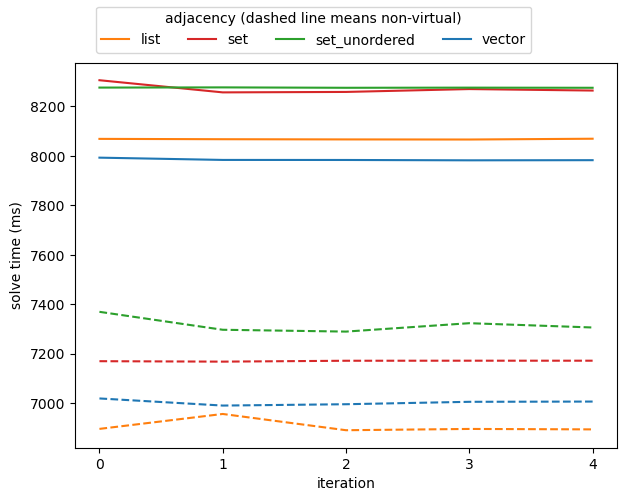

In [2]:
results_warmup = pd.read_csv(
       "results-warmup.csv",
       engine = "python",
       sep = '\s*,\s*',
       usecols = ["iteration", "solve", "adjacency", "virtual"])

colors = {"vector": "tab:blue", "list": "tab:orange", "set": "tab:red", "set_unordered": "tab:green"}

fig, axs = plt.subplots(1, 1, figsize = (7, 5), sharey = True, sharex = True)

results_warmup = results_warmup.groupby(["iteration", "adjacency", "virtual"], as_index = False).mean()
for head, data in results_warmup.groupby(["virtual", "adjacency"]):
       axs.plot(data["iteration"], data["solve"],
              linestyle = "solid" if head[0] else "dashed",
              color = colors[head[1]],
              label = ("" if head[0] else "_") + head[1])

axs.set_xticks([0, 1, 2, 3, 4])
axs.set_xlabel("iteration")

axs.set_ylabel("solve time (ms)")

fig.subplots_adjust(top = 0.88)
fig.legend(title = "adjacency (dashed line means non-virtual)", loc = 'upper center', ncol = 4)

We can see that the performance varies very little between different iterations although there is a downwards trend as expected.

The only other interesting finding is the relatively sharp drop after the first iteration with the 'vector' implementation and then a steady performance.
After examining the source code this lead us to finding a potential improvement of the implementation. The `std::vector` is initialized to its default capacity and then expands as it is emplaced into. When resetting to prepare for the next iterations the vector clears, but this does not change the capacity. Therefore, the subsequent iterations don't have to allocate as much memory (meaning not as many allocation calls, not less memory consumed). With DIMACS format of the input the number of clauses is provided, so the implementation could approximate the capacity needed for the adjacency vector.

As there is a small but clear performance improvement after a few iterations and multiple iterations make the solving part of the algorithm more significant we decide to use the value 5 for 'iterations'. A higher value would probably provide even slightly better results but at the cost of very long measurement times.

# Container implementations

Next we compare different adjacency container implementations.

We measure using the 'perf' tool which allows us to measure hardware counters such as branches and cache loads.
This allows us to more finely analyse the performance changes caused by different implementation and to compare the results with our expectations.

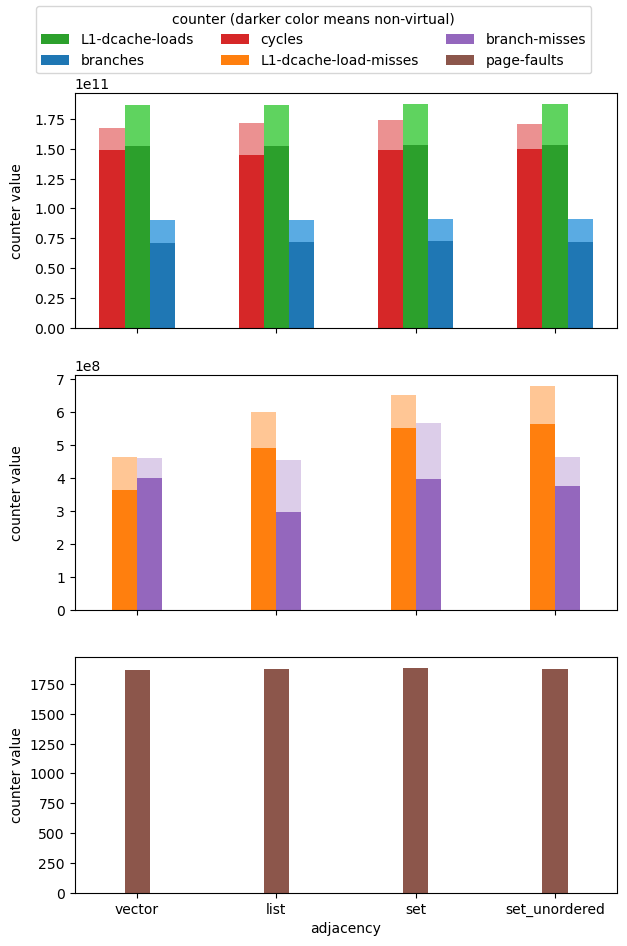

In [3]:
results_perf = pd.read_csv(
       "results-perf.csv",
       engine = "python",
       sep = '\s*,\s*',
       usecols = ["value", "counter", "adjacency", "virtual"])

results_perf["counter"] = results_perf["counter"].transform(lambda x: x[:-2])

results_perf = results_perf.groupby(["counter", "adjacency", "virtual"], as_index = False).mean()

fig, axs = plt.subplots(3, figsize = (7, 10), sharex = True)

width = 0.18

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

counter_dict = {
    "cycles": [-1, "tab:red", 0],
    "L1-dcache-loads": [0, "tab:green", 0],
    "branches": [1, "tab:blue", 0],
    "L1-dcache-load-misses": [-0.5, "tab:orange", 1],
    "branch-misses": [0.5, "tab:purple", 1],
    "page-faults": [0, "tab:brown", 2]}

adjacency_dict = {
    "vector": 0,
    "list": 1,
    "set": 2,
    "set_unordered": 3}

for head, data in results_perf.groupby(["counter", "adjacency", "virtual"]):
    params = counter_dict[head[0]]
    color = params[1]
    axs[params[2]].bar(
        adjacency_dict[head[1]] + params[0] * width,
        data["value"],
        width,
        color = adjust_lightness(color, 1.5) if head[2] else color,
        zorder = 1 if head[2] else 2,
        label = ("" if not head[2] and head[1] == "vector" else "_") + head[0])

axs[2].set_xlabel("adjacency")
axs[2].set_xticks([0, 1, 2, 3], labels = adjacency_dict.keys())

for a in axs:
    a.set_ylabel("counter value")

fig.subplots_adjust(top=0.91)
fig.legend(title = "counter (darker color means non-virtual)", loc = 'upper center', ncol = 3)
fig.align_ylabels()

Firstly, we can see that different adjacency implementation have very little impact on the performance (the cycles counter) but we will analyse this later.

The page faults don't change very much between the implementations as expected, because there is not a significant difference in the memory footprint between the containers.
This is not to say that there is no difference but the differences are in the region of a few pages with total page fault counts being aroung 1800.

The number of total branches and cache loads also doesn't vary much.
Cache loads were expected to stay the same, because the total memory fetched is almost identical.
Branching should be more prevalent in the `std::set` version and it is indeed but the difference is very small.
We will analyse this later.

The interesting counters which do vary are the misses.
As `std::set` internally uses comparisons, its branch misses are the highest.
As `std::vector` uses contiguous memory, its cache misses are the lowest.
It is not surprising to see the more complicated `std::unordered_set` causing more misses overall.
It is however surprising to see that `std::list` causes the least amount of branch misses.

The situtation with `std::list` being the most efficient implementation could be explained by the particularities of the 'vector' implementation.
The interface of the adjacency container dictates that the container doesn't have to keep order, but it must be able to erase its elements during iteration.
Other implementations can do this trivially but with `std::vector` we have to first swap the to-be-erased element with the last one and then `pop_back`. That changes the order but it is allowed by the algorithm. However, this change in the memory location can cause the branch predictions to perform worse.

# Profiling

Next we will take a look at why the different adjacency implementations don't affect the performance as much as we hoped.

The trivial answer could be that the program simply doesn't spend much time in code affected by the adjacency implementation.
To get an estimate of how significant to the performance the adjacency container really is we can use profiling.
Even if we managed to speed up the adjacency implementation infinitely, the performance boost would still be bounded by the proportion of time the programs spends in such code.

For profiling we use perf, specifically perf-record.

We also measure only one input with one set of parameters as it is difficult to make an average of a call graph.
We believe that this is still valuable information as the ratios between routines should stay consistent between different inputs.

We use a different configuration to the other measurements as mentioned earlier in this report.
We used 'vector' adjacency and the virtual option. Virtual calls with no optimizations show us a clearer picture of the call relationships.
Vector adjacency is the simplest in container implementation but also more sophisticated in the implementation of the iteration of the adjacent clauses, which makes this measurement more of an upper bound.

![file not found](call-graph.svg)

First, it should be noted that there are three traces which lead to `adjacent_for_each`, one to `adjacent_add` and none to the other two functions.
`adjacent_remove` isn't called with the parameters used and `adjacent_reset` is only called when resetting between two iterations so it was only called four times and the profiling couldn't sample it. That also means that it's performance impact is almost certainly minimal.
When analysing the time spent in `adjacent_for_each`, we should subtract the time taken by `std::function`,
because it is the inner function called by the adjacency but is not part of the adjacency implementation.

After considering the before mentioned we can see from the graph that the program spends around 9.5% of the time in adjancency.
This explains why different implementations cannot have large impacts on the performance, as even the greatest performance improvement could have an impact of around 10%.
This approximation also doesn't consider the fact that optimizations and virtual call elision will have a further impact on this ratio.
We also note that although the performance difference between adjancency implementations wasn't large, it was around a few percent which coincides with the findings from profiling.

# Virtual calls

The measured SAT solver was originally programmed with the goal of writing conceptually understandable code at any cost to the performance.
That means that it uses virtual calls, virtual inheritance, `std::function` etc. It also means that the design is made in such a way that even the DPLL and CDCL algorithms, which are never taught as two versions of the same algorithm, share the basic solve structure, which is very expensive both design-wise and implementation-wise. This decision was made on purpose with the idea that it would be interesting to later see how much performance could be gained by measuring and improving just the low level implementation, not design.

The most obvious performance improvement is the elimination of virtual calls.
We managed to extend the implementation of the solver to support two modes: one with the original structure of inheritance and other with elimination of virtual inheritance and virtual calls with the help of template programming. This was done at the cost of a very long compilation time. The enhanced solver takes minutes to compile compared to seconds it took the original version.

As interested as we are in measuring compile time performance, this is a notoriously hard task in C++, so we measured just the runtime one. It is still worth noting that the virtual calls could be eliminated much further, but we arrived at a limit caused by the compile-time performance. The elimination of the virtual calls works by compiling the code for each parameter combination separately and dispatching at the beginning of the program. When we wanted to support more than around a thousand combinations of the parameters, the compilation took too long (tens of minutes). This technique also greatly increases the executable size, as there is much more code being generated. The size of the binary could become a bottlenech too.

To find out how many virtual calls we really eliminated, we used an instrumentation tool - Pin.
With it we were able to instrument every indirect function call. Not all indirect function calls used in the program must be virtual calls, but all virtual calls are indirect function calls so we should get an idea of how many we eliminated. Other great source of indirect calls is probably `std::function` which could be also eliminated with template programming and optimizations. Therefore the total number of indirect function calls is a good estimate of the potential maximal performance benefit for "virtual elimination" that we have partially done.

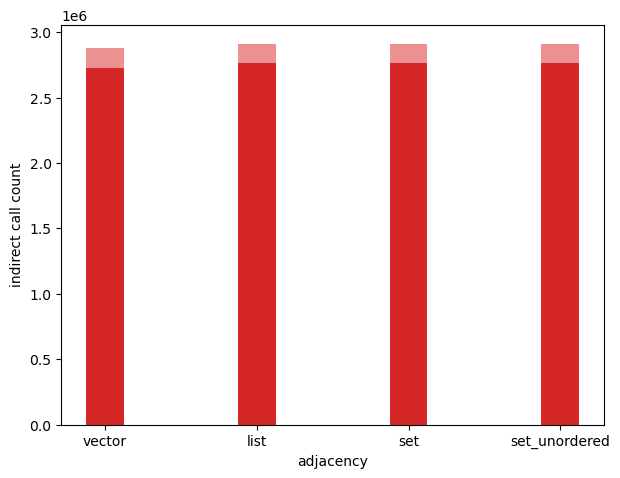

In [4]:
results_instr = pd.read_csv(
    "results-instr.csv",
    engine = "python",
    sep = '\s*,\s*')

results_instr = results_instr.groupby(["adjacency", "virtual"], as_index = False).mean()

fig, axs = plt.subplots(figsize = (7, 5), sharex = True)

width = 0.25
x = np.arange(4)

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

adjacency_dict = {
    "vector": 0,
    "list": 1,
    "set": 2,
    "set_unordered": 3}

for head, data in results_instr.groupby(["adjacency", "virtual"]):
    color = "tab:red"
    axs.bar(
        adjacency_dict[head[0]],
        data["count"],
        width,
        color = adjust_lightness(color, 1.5) if head[1] else color,
        zorder = 1 if head[1] else 2)

axs.set_xlabel("adjacency")
axs.set_xticks([0, 1, 2, 3], labels = adjacency_dict.keys())
axs.set_ylabel("indirect call count")

fig.subplots_adjust(top=0.91)
fig.align_ylabels()

We can see that we eliminated only a few percent of the indirect calls.
This is expected, because we eliminated the calls from the top down, meaning that the less frequently called bulkier routines where optimized first.
Most of the low level routines weren't optimized and we assume that there lie many potential performance improvements of the program.